In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertTokenizer


/localscratch/liangqi1/miniconda3/envs/transformer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
save_path = '/egr/research-slim/liangqi1/LLM/transformer-study/data/encoded_texts.pt'  # 替换为你的文件路径
encoded_texts = torch.load(save_path)

vocab_size = tokenizer.vocab_size  # 21128（BERT 预训练词汇表大小）
embedding_dim = 256  # 768 维度（和 BERT 一致）

# 定义嵌入层
embedding_layer = nn.Embedding(vocab_size, embedding_dim)
sample = encoded_texts.input_ids[0]
mask = encoded_texts.attention_mask[0]
embedded_tokens = embedding_layer(sample)
print(embedded_tokens.shape)
print(mask.shape)

<ipython-input-12-3fef5780bec7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoded_texts = torch.load(save_path)


torch.Size([512, 256])
torch.Size([512])


# **📌 Self-Attention & Multi-Head Attention（自注意力 & 多头注意力）**
在 Transformer 模型中，注意力机制是核心部分。我们这里讨论 **单头注意力（Single-Head Attention）** 和 **多头注意力（Multi-Head Attention）** 的实现。

---

## **🔹 1. 单头注意力（Single-Head Attention）**
### **📌 输入与维度**
- **输入（X）**: `X.shape = (512, 256)`  
  - **512**: 句子中的 token 数量（`seq_len=512`）。
  - **256**: 每个 token 的特征维度（`embedding_dim=256`）。

- **权重矩阵（Weight Matrices）**
  - `W_q.shape = (256, 256)`
  - `W_k.shape = (256, 256)`
  - `W_v.shape = (256, 256)`

- **计算 Q, K, V**
  $$
  Q = X W_q, \quad K = X W_k, \quad V = X W_v
  $$
  - `Q.shape = (512, 256)`
  - `K.shape = (512, 256)`
  - `V.shape = (512, 256)`

### **📌 计算注意力**
#### **🎯 1. 计算注意力分数（Attention Scores）**
$$
\text{Attention Scores} = \frac{Q K^T}{\sqrt{d_k}}
$$
- `QK^T.shape = (512, 512)`，即 **每个 token 对所有 token 的相似度**。
- `d_k = 256`，因此进行缩放 `\sqrt{d_k}` 防止梯度过大。

#### **🎯 2. 计算 Softmax 权重**
$$
\text{Attention Weights} = \text{softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right)
$$
- `Attention Weights.shape = (512, 512)`
- 归一化使注意力分布在 `[0,1]` 之间。

#### **🎯 3. 计算加权输出**
$$
\text{Attention Output} = \text{Attention Weights} \cdot V
$$
- `Attention Output.shape = (512, 256)`



In [15]:
## attentional mask construct
seq_len = mask.shape[0]
# 扩展维度，使其变为 (1, 1, seq_len, seq_len)
attn_mask = mask.unsqueeze(0).unsqueeze(0).expand(1, seq_len, seq_len) == 0
attn_mask

tensor([[[False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True]]])

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model):
        """
        单头注意力机制（Self-Attention）
        :param d_model: 词嵌入维度（embedding_dim），比如 256
        """
        super(SingleHeadAttention, self).__init__()
        self.d_model = d_model  # 词向量维度
        self.d_k = d_model  # 这里单头，所以 d_k = d_model

        # 线性变换层，用于计算 Q, K, V
        self.W_q = nn.Linear(d_model, d_model, bias=False)  # (d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model, bias=False)  # (d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model, bias=False)  # (d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)  # 用于计算注意力权重

    def forward(self, x,attn_mask):
        """
        前向传播
        :param x: 输入张量 (batch_size, seq_len, d_model)
        :return: 注意力输出 (batch_size, seq_len, d_model)
        """
        # 计算 Q, K, V
        Q = self.W_q(x)  # (batch_size, seq_len, d_model)
        K = self.W_k(x)  # (batch_size, seq_len, d_model)
        V = self.W_v(x)  # (batch_size, seq_len, d_model)

        # 计算 QK^T / sqrt(d_k)
        d_k = self.d_k ** 0.5  # 缩放因子
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / d_k  # (batch_size, seq_len, seq_len)
        attention_scores.masked_fill_(attn_mask, -1e9)
        # 计算 softmax 权重
        attention_weights = self.softmax(attention_scores)  # (batch_size, seq_len, seq_len)

        # 计算加权 V
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, seq_len, d_model)

        return attention_output, attention_weights


In [18]:
# 定义超参数
d_model = 256     # 词向量维度 256

# 生成随机嵌入输入
x = embedded_tokens.unsqueeze(0)

# 初始化注意力层
single_head_attention = SingleHeadAttention(d_model)

# 运行注意力计算
attention_output, attention_weights = single_head_attention(x,attn_mask)

# 查看结果形状
print("Attention Output Shape:", attention_output.shape)  # (1, 10, 256)
print("Attention Weights Shape:", attention_weights.shape)  # (1, 10, 10)


Attention Output Shape: torch.Size([1, 512, 256])
Attention Weights Shape: torch.Size([1, 512, 512])


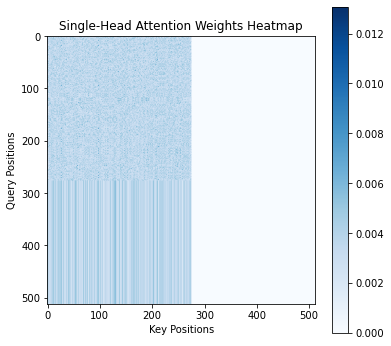

In [19]:
import matplotlib.pyplot as plt

def plot_attention_weights(attention_weights):
    plt.figure(figsize=(6,6))
    plt.imshow(attention_weights[0].detach().numpy(), cmap='Blues')
    plt.colorbar()
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.title("Single-Head Attention Weights Heatmap")
    plt.show()

# 绘制注意力热图
plot_attention_weights(attention_weights)


---

## **🔹 2. 多头注意力（Multi-Head Attention, MHA）**
### **📌 输入与维度**
- **输入（X）**: `X.shape = (512, 256)`
- **多头数量（num_heads）**: 设 `num_heads=8`
- **每个头的 `d_k, d_v` 计算**
  

- **权重矩阵（Weight Matrices）**
  - `W_q.shape = (256, 256)`
  - `W_k.shape = (256, 256)`
  - `W_v.shape = (256, 256)`

- **计算 Q, K, V**
  $$
  Q = X W_q, \quad K = X W_k, \quad V = X W_v
  $$
  - `Q.shape = (512, 256)`
  - `K.shape = (512, 256)`
  - `V.shape = (512, 256)`

- **拆分成 8 个头**
  
  $Q = Q.reshape(512, 8, 32), \quad K = K.reshape(512, 8, 32), \quad V = V.reshape(512, 8, 32)$
  
  - 现在 `Q, K, V` 变为 **(512, 8, 32)**，每个头计算一个 `d_k = 32` 的注意力。

### **📌 计算多头注意力**
#### **🎯 1. 每个头独立计算注意力**
$$
\text{Attention}_i = \text{softmax} \left( \frac{Q_i K_i^T}{\sqrt{d_k}} \right) V_i
$$
- `Q_i.shape = (512, 32)`
- `K_i.shape = (512, 32)`
- `V_i.shape = (512, 32)`
- `Attention_i.shape = (512, 32)`

#### **🎯 2. 拼接多个头**
$$
\text{MultiHead Output} = \text{Concat}(\text{Attention}_1, ..., \text{Attention}_8)
$$
- `Concat.shape = (512, 256)`

#### **🎯 3. 最终线性变换**
$$
\text{MultiHead Output} = \text{Concat}(\text{Attention}_1, ..., \text{Attention}_8) W^O
$$
- `W_o.shape = (256, 256)`
- `MultiHead Output.shape = (512, 256)`

---



In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        """
        多头注意力机制
        :param d_model: 输入嵌入维度（比如 256）
        :param num_heads: 头的数量（比如 8）
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model 必须能被 num_heads 整除！"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 每个头的维度

        # 线性变换矩阵
        self.W_q = nn.Linear(d_model, d_model, bias=False)  
        self.W_k = nn.Linear(d_model, d_model, bias=False)  
        self.W_v = nn.Linear(d_model, d_model, bias=False)  
        self.W_o = nn.Linear(d_model, d_model, bias=False)  

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, attn_mask):
        """
        :param x: 输入张量 (batch_size, seq_len, d_model)
        :param attn_mask: Mask (batch_size, 1, seq_len) → 需要扩展为 (batch_size, num_heads, seq_len, seq_len)
        :return: 多头注意力输出 (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.shape

        # 计算 Q, K, V
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # 计算 Attention Scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)

        # 处理 Mask（True 的地方设为 -1e9，防止关注 Padding）
        # 处理 Mask（True 的地方设为 -1e9，防止关注 Padding）
        attn_mask = attn_mask.squeeze(1)  # 确保 Mask 维度正确 (batch_size, seq_len, seq_len)
        attn_mask = attn_mask.unsqueeze(1).expand(batch_size, self.num_heads, seq_len, seq_len)  # (batch_size, num_heads, seq_len, seq_len)
        scores.masked_fill_(attn_mask, -1e9)

        # 计算 Softmax
        attn = self.softmax(scores)  # (batch_size, num_heads, seq_len, seq_len)

        # 计算最终加权 V
        context = torch.matmul(attn, V)  # (batch_size, num_heads, seq_len, d_k)

        # 重新排列并拼接多头输出
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)

        # 经过 W_o 线性变换
        output = self.W_o(context)  # (batch_size, seq_len, d_model)

        return output, attn


In [3]:
# 定义超参数
batch_size = 2    # 批量大小
seq_len = 512     # 句子长度
d_model = 256     # 词向量维度
num_heads = 8     # 8 头注意力

# 生成随机嵌入输入
x = torch.randn(batch_size, seq_len, d_model)

# 生成 Mask (batch_size, seq_len)，1 表示 Token，0 表示 Padding
mask = torch.randint(0, 2, (batch_size, seq_len), dtype=torch.bool)  # 1 = Token, 0 = Padding

# 将 Mask 变为 (batch_size, 1, seq_len, seq_len)，确保 softmax 计算时 `[PAD]` 位置被屏蔽
attn_mask = mask.unsqueeze(1).unsqueeze(2).expand(batch_size, 1, seq_len, seq_len) == 0

# 初始化多头注意力层
multi_head_attention = MultiHeadAttention(d_model, num_heads)

# 运行注意力计算
output, attention_weights = multi_head_attention(x, attn_mask)

# 查看结果形状
print("Multi-Head Attention Output Shape:", output.shape)  # (batch_size, seq_len, d_model)
print("Attention Weights Shape:", attention_weights.shape)  # (batch_size, num_heads, seq_len, seq_len)


RuntimeError: expand(CPUBoolType{[2, 1, 1, 512, 512]}, size=[2, 8, 512, 512]): the number of sizes provided (4) must be greater or equal to the number of dimensions in the tensor (5)

## **🔹 3. 单头 vs 多头注意力对比**
| 机制 | `d_model` | `d_k`（Key 维度） | `d_v`（Value 维度） | 计算方式 |
|------|----------|----------------|----------------|------------|
| **单头注意力（Single-Head Attention）** | `256` | `256` | `256` | 只计算 1 次注意力 |
| **多头注意力（Multi-Head Attention）** | `256` | `32`（8 头拆分） | `32` | `8` 组 Attention 并行计算后拼接 |



---

## **🔹 4. 代码示例**
```python
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model 必须能被 num_heads 整除！"
        
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 每个头的维度
        self.d_model = d_model

        # 线性变换 Q, K, V
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # 计算 Q, K, V 并 reshape 成 (batch_size, num_heads, seq_len, d_k)
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # 计算注意力分数
        d_k = self.d_k ** 0.5
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / d_k
        attention_weights = self.softmax(attention_scores)

        # 计算加权 V
        output = torch.matmul(attention_weights, V)

        # 重新拼接多头输出
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        # 经过 W_o 线性变换
        return self.W_o(output)
```

---

🚀 **这样，你就完整掌握了单头注意力和多头注意力的核心计算过程和代码实现！🎉**